Using space navigation v2 environment test these algorithms: DQN, PPO, A2C

In [16]:
# Imports
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from stable_baselines3 import DQN, A2C, PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.logger import configure
from stable_baselines3.common.callbacks import BaseCallback

from Environment_Creator import env_creator, Environments_enum

In [2]:
# Fetch environment
def make_navigation_env():
    return env_creator(Environments_enum.Navigation_v2.value)

# Register and make environment
gym.register(id="SpaceNavigation_v0", entry_point=make_navigation_env)
env = gym.make("SpaceNavigation_v0")

In [3]:
class MultiAlgorithmRewardLogger(BaseCallback):
    def __init__(self, algo_name):
        super().__init__()
        self.algo_name = algo_name  # Store algorithm name
        self.episode_rewards = []   # Store rewards for each episode
        self.current_episode_reward = 0  # Track reward within an episode

    def _on_step(self) -> bool:
        # Extract reward from current step
        reward = self.locals["rewards"]
        self.current_episode_reward += reward

        # Check if episode is done
        if self.locals["dones"]:
            self.episode_rewards.append(self.current_episode_reward)
            self.current_episode_reward = 0  # Reset for the next episode
        return True

reward_logger_ppo = MultiAlgorithmRewardLogger("PPO")
reward_logger_dqn = MultiAlgorithmRewardLogger("DQN")
reward_logger_a2c = MultiAlgorithmRewardLogger("A2C")

reward_loggers = [reward_logger_ppo, reward_logger_dqn, reward_logger_a2c]

In [4]:
# Smaller network for testing purposes
# policy_kwargs=dict(net_arch=[64, 64]),  # Smaller network

In [5]:
# Configure model selection function
def set_model(algo, policy):
    '''
        Selects a model algorithm: DQN, PPO, A2C. Model will be configured and ready for training.
        Args:
            algo: input algorithm as str: DQN, PPO, A2C
            policy: input policy as str: MlpPolicy, etc... 
        Returns:
            stable baselines3 model
    '''
    match algo:
        case "DQN":
            model = DQN(
                policy,
                env,
                learning_rate=5e-4,  # Learning rate for better convergence
                buffer_size=5000,  # Replay buffer size [tested: 10000]
                learning_starts=500,  # Number of steps before training starts
                batch_size=16,  # Mini-batch size for training [tested: 128]
                gamma=0.95,  # Discount factor for future rewards
                target_update_interval=500,  # How often to update target network [tested: 500]
                train_freq=10,  # Train every 10 steps
                exploration_fraction=0.3,  # Explore more in the beginning
                verbose=1,  # Print training information
                tensorboard_log="./logs",  # Logging
                device='cuda'
            )
        case "PPO":
            model = PPO(
                policy,
                env, 
                learning_rate=1e-4,  # Lower LR for stable updates in physics-based problems
                n_steps=1024,  # Larger batch size helps smooth policy updates [tested: 2048]
                batch_size=16,  # Batch size large for better stability [tested: 256]
                n_epochs=10,  # More updates per batch (stabilizes training)
                gamma=0.999,  # High discount factor for long-term rewards
                gae_lambda=0.95,  # Generalized Advantage Estimation (smooths advantage estimation)
                clip_range=0.2,  # Standard PPO clipping
                ent_coef=0.01,  # Encourage some exploration
                vf_coef=0.5,  # Balance between policy and value function loss
                max_grad_norm=0.5,  # Prevent exploding gradients
                target_kl=0.05,  # Prevent large policy updates (for stable training) [tested with 0.02 - updated to handle larger updates due to early stopping]
                tensorboard_log="./logs",  # Logging
                verbose=1,
                device='cuda'  # Use GPU if available
            )
        case "A2C":
            model = A2C(
                policy=policy,
                env=env,
                learning_rate=3e-4,
                n_steps=3,  # Default value, you can increase this to match batch size preferences [tested: 5]
                gamma=0.99,  # From the table
                gae_lambda=1.0,  # From the table, helps with Generalized Advantage Estimation
                ent_coef=0.01,  # From the table, controls entropy for exploration
                vf_coef=0.5,  # From the table, balance between policy and value function
                max_grad_norm=0.5,  # From the table, limits gradient explosion
                rms_prop_eps=1e-5,  # Default value for RMSProp, stability for gradient updates
                use_rms_prop=True,  # Using RMSProp for stable optimization
                use_sde=False,  # Enable for stochastic networks
                sde_sample_freq=-1,  # Only relevant if use_sde=True
                normalize_advantage=False,  # Keep advantage normalization as False unless needed
                stats_window_size=100,  # The size of the window for stats tracking
                tensorboard_log="./logs",  # TensorBoard logs
                policy_kwargs=None,  # For additional custom policy configuration (e.g., network architecture)
                verbose=1,  # Verbosity level, 1 will print some details during training
                seed=None,  # Set a seed for reproducibility if desired
                device='auto',  # Automatically selects the device (CPU or GPU)
                _init_setup_model=True,  # Initialize model setup
            )
        case _:
            raise ValueError(f"Unknown algorithm type: {algo}")

    return model

In [6]:
# Set the models to a collection
models = []
models.append(set_model("PPO", "MlpPolicy"))
models.append(set_model("DQN", "MlpPolicy"))
models.append(set_model("A2C", "MlpPolicy"))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [26]:
iter = 0
# Train and save
for model, logger in zip(models, reward_loggers):
    iter = iter + 1

    # Log training progress
    # log_dir = "./logs"
    # new_logger = configure(log_dir, ["stdout", "tensorboard"])
    # model.set_logger(new_logger)
    
    model.learn(
        total_timesteps=250_000,
        log_interval=50,
        reset_num_timesteps=False, # for continual training
        progress_bar=False,
        callback=logger
    )
    model.save(f"spacenavigation_comp_{iter}")

Logging to ./logs\PPO_1
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 99.9        |
|    ep_rew_mean          | -93.1       |
| time/                   |             |
|    fps                  | 541         |
|    iterations           | 50          |
|    time_elapsed         | 94          |
|    total_timesteps      | 151552      |
| train/                  |             |
|    approx_kl            | 0.010010472 |
|    clip_fraction        | 0.0799      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.17       |
|    explained_variance   | 0.991       |
|    learning_rate        | 0.0001      |
|    loss                 | 0.257       |
|    n_updates            | 1470        |
|    policy_gradient_loss | -0.0117     |
|    value_loss           | 2.97        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_le

In [27]:
# Load a Model for Continued Training and reattach the reward logger
# models = []
loggers = [reward_logger_ppo, reward_logger_dqn, reward_logger_a2c]
algo_names = ["PPO", "DQN", "A2C"]

# Load each saved model
for i, algo in enumerate(algo_names, start=1):
    model_path = f"spacenavigation_comp_{i}.zip"
    
    if algo == "PPO":
        model = PPO.load(model_path, env=env)
    elif algo == "DQN":
        model = DQN.load(model_path, env=env)
    elif algo == "A2C":
        model = A2C.load(model_path, env=env)

    # Attach the correct logger
    reward_logger = loggers[i - 1]
    
    # Continue training with logger attached
    model.learn(
        total_timesteps=250_000,
        reset_num_timesteps=False,  # Continue training without resetting
        log_interval=50,
        callback=reward_logger,  # Reattach logger
        progress_bar=False
    )

    # Save again after additional training
    model.save(f"spacenavigation_comp_{i}_updated")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs\PPO_1
Early stopping at step 8 due to reaching max kl: 0.08
Early stopping at step 1 due to reaching max kl: 0.08
Early stopping at step 3 due to reaching max kl: 0.21
Early stopping at step 8 due to reaching max kl: 0.08
Early stopping at step 6 due to reaching max kl: 0.09
Early stopping at step 8 due to reaching max kl: 0.09
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 84.3        |
|    ep_rew_mean          | -52.4       |
| time/                   |             |
|    fps                  | 562         |
|    iterations           | 50          |
|    time_elapsed         | 91          |
|    total_timesteps      | 402432      |
| train/                  |             |
|    approx_kl            | 0.013472882 |
|    clip_fraction        | 0.175       |
|    clip_range           | 0.2         |
|    entropy_loss         | -

In [28]:
rewards_PPO = []
rewards_DQN = []
rewards_A2C = []

# Define function to evaluate the model
def evaluate_model(model, env, num_episodes=50):
    """
    Runs the model on the environment for a fixed number of episodes 
    and records rewards.

    Returns:
        rewards_per_episode: List of total rewards per episode
    """
    rewards_per_episode = []

    for _ in range(num_episodes):
        obs = env.reset()[0]
        done = False
        total_reward = 0

        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = env.step(action)

            if str(model.__class__.__name__) == "PPO":
                rewards_PPO.append(reward)
            if str(model.__class__.__name__) == "DQN":
                rewards_DQN.append(reward)
            if str(model.__class__.__name__) == "A2C":
                rewards_A2C.append(reward)
                
            done = done or truncated
            total_reward += reward

        rewards_per_episode.append(total_reward)

    return np.array(rewards_per_episode).tolist()

# Evaluate each trained model
num_eval_episodes = 50
eval_results = {}

for i, model in enumerate(models):
    model = model.load(f"spacenavigation_comp_{i + 1}_updated")
    algo = str(model.__class__.__name__)  # Ensure it's a string
    rewards = evaluate_model(model, env, num_eval_episodes)
    
    print(f"Evaluating {algo}, Reward shape: {np.shape(rewards)}")  # Debugging output
    
    eval_results[algo] = rewards  # Store properly formatted rewards

# Print summary statistics
for algo, rewards in eval_results.items():
    print(f"{algo} - Mean Reward: {np.mean(rewards):.2f}, Std Dev: {np.std(rewards):.2f}")

Evaluating PPO, Reward shape: (50,)
Evaluating DQN, Reward shape: (50,)
Evaluating A2C, Reward shape: (50,)
PPO - Mean Reward: 12.09, Std Dev: 0.00
DQN - Mean Reward: 1.55, Std Dev: 0.00
A2C - Mean Reward: -120.20, Std Dev: 0.00


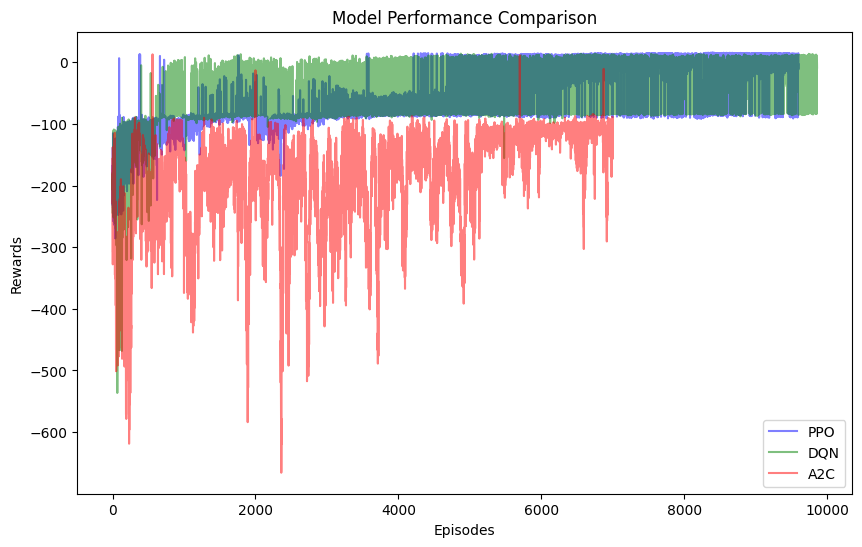

In [32]:
rewards_PPO = np.array(rewards_PPO)
rewards_DQN = np.array(rewards_DQN)
rewards_A2C = np.array(rewards_A2C)

plt.figure(figsize=(10, 6))

# Plot each model's rewards
plt.plot(rewards_PPO, label='PPO', color='blue', alpha=0.5)
plt.plot(rewards_DQN, label='DQN', color='green', alpha=0.5)
plt.plot(rewards_A2C, label='A2C', color='red', alpha=0.5)

# Add titles and labels
plt.title('Model Performance Comparison')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()

# Show plot
plt.show()

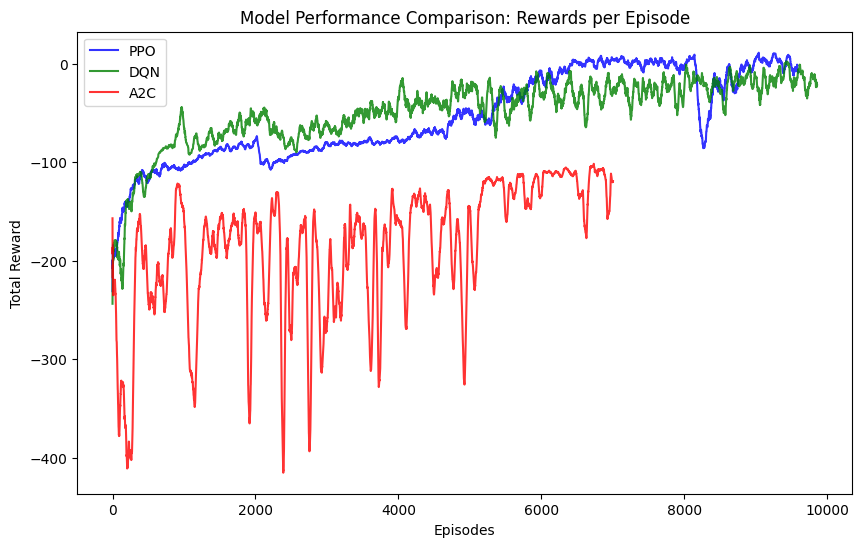

In [33]:
# Convert lists to NumPy arrays for better plotting
rewards_PPO = np.array(reward_logger_ppo.episode_rewards)
rewards_DQN = np.array(reward_logger_dqn.episode_rewards)
rewards_A2C = np.array(reward_logger_a2c.episode_rewards)

def smooth(y, window_size=50):
    return pd.Series(y).rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(10, 6))

# Plot rewards for each model with different colors
plt.plot(smooth(rewards_PPO.flatten()), label="PPO", color="blue", alpha=0.8)
plt.plot(smooth(rewards_DQN.flatten()), label="DQN", color="green", alpha=0.8)
plt.plot(smooth(rewards_A2C.flatten()), label="A2C", color="red", alpha=0.8)

# Labels and Title
plt.title("Model Performance Comparison: Rewards per Episode")
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.legend()

# Show the plot
plt.show()

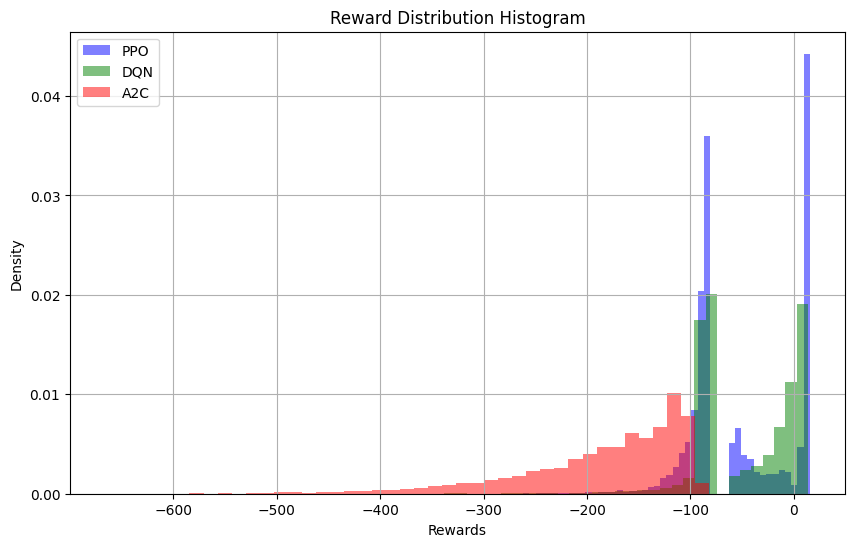

In [39]:
plt.figure(figsize=(10, 6))

plt.hist(rewards_PPO, bins=50, alpha=0.5, label="PPO", color="blue", density=True)
plt.hist(rewards_DQN, bins=50, alpha=0.5, label="DQN", color="green", density=True)
plt.hist(rewards_A2C, bins=50, alpha=0.5, label="A2C", color="red", density=True)

plt.xlabel("Rewards")
plt.ylabel("Density")
plt.title("Reward Distribution Histogram")
plt.legend()
plt.grid(True)
plt.show()

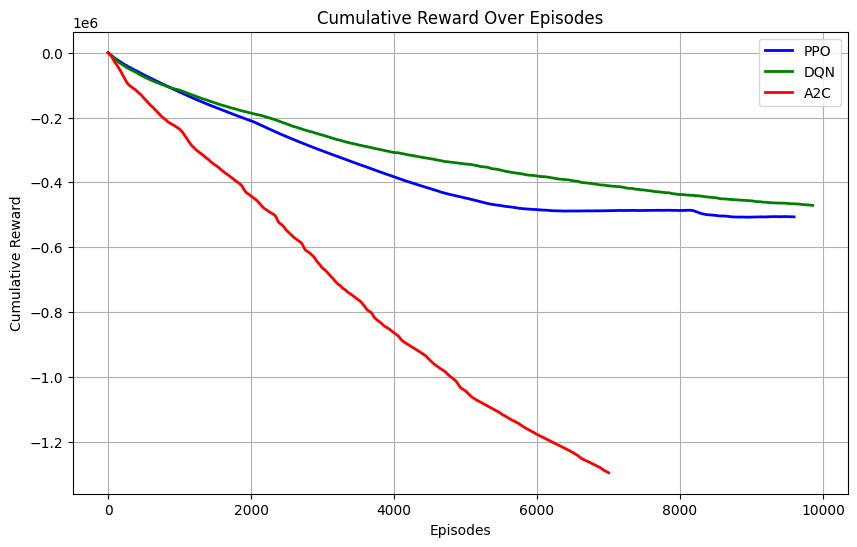

In [40]:
cumulative_rewards_PPO = np.cumsum(rewards_PPO)
cumulative_rewards_DQN = np.cumsum(rewards_DQN)
cumulative_rewards_A2C = np.cumsum(rewards_A2C)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_rewards_PPO, label="PPO", color="blue", linewidth=2)
plt.plot(cumulative_rewards_DQN, label="DQN", color="green", linewidth=2)
plt.plot(cumulative_rewards_A2C, label="A2C", color="red", linewidth=2)

plt.title("Cumulative Reward Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()
plt.grid(True)
plt.show()